In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# HS KePSH1 PV데이터 추출

In [6]:
# HS PV 데이터 리딩
data = pd.read_csv('./211104_kepsh1.csv', parse_dates = True)

In [7]:
data

,Unnamed: 0,Time,PV_kepsh1(W),PVT_kepsh1(W),Slope_solar_radiation(w/m2),FC(W),HP_kepsh1(W),Cons_kepsh1(W),Prod_kepsh1(W),Cons_acc_kepsh1(Wh),Prod_acc_kepsh1(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain
0,0,2021-04-27 10:59:00,5400.0,-9.0,424.842,0.0,249.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN
1,1,2021-04-27 11:00:00,5655.0,-9.0,437.187,0.0,274.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN
2,2,2021-04-27 11:01:00,5777.0,-9.0,455.580,0.0,276.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN
3,3,2021-04-27 11:02:00,6116.0,-9.0,493.072,0.0,276.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN
4,4,2021-04-27 11:03:00,5049.0,-9.0,410.092,0.0,276.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224873,224874,2021-11-04 16:24:00,959.0,183.0,82.673,374.0,29.0,635.0,1516.0,2.031135e+06,3.515194e+06,635.0,2.031135e+06,0.418865,1.000000,0.577816,1.0,1.730655
224874,224875,2021-11-04 16:25:00,912.0,174.0,78.300,374.0,29.0,634.0,1460.0,2.031146e+06,3.515219e+06,634.0,2.031146e+06,0.434247,1.000000,0.577815,1.0,1.730658
224875,224876,2021-11-04 16:26:00,874.0,167.0,74.750,374.0,29.0,634.0,1415.0,2.031156e+06,3.515242e+06,634.0,2.031156e+06,0.448057,1.000000,0.577814,1.0,1.730661
224876,224877,2021-11-04 16:27:00,848.0,161.0,72.533,375.0,29.0,1423.0,1384.0,2.031180e+06,3.515265e+06,1384.0,2.031180e+06,1.000000,0.972593,0.577817,1.0,1.730652


In [8]:
df_kepsh1_HS =  pd.DataFrame()
df_kepsh1_HS['Time'] = data['Time']
df_kepsh1_HS['Slope_solar_radiation(w/m2)'] = data['Slope_solar_radiation(w/m2)']
df_kepsh1_HS['PV_kepsh1_HS(W)'] = data['PV_kepsh1(W)']

In [5]:
# HS PV데이터 중 기저부하 삭제 
df_kepsh1_HS = df_kepsh1_HS[df_kepsh1_HS['PV_kepsh1_HS(W)'] >=0]

In [9]:
df_kepsh1_HS['Time'] = pd.to_datetime(df_kepsh1_HS['Time'])

# 디오텍 KePSH1 PV데이터 추출

In [10]:
# 디오텍 PV 데이터 리딩
data2 = pd.read_csv('./kepsh1_PV(W).csv', parse_dates = True)

In [11]:
df_kepsh1_DT =  pd.DataFrame()
df_kepsh1_DT['Time'] = data2['Time']
df_kepsh1_DT['PV_kepsh1_DT(W)'] = data2['KP1_PV(W)']

In [12]:
df_kepsh1_DT['Time'] = pd.to_datetime(df_kepsh1_DT['Time'])

In [25]:
df_kepsh1_DT.to_csv('./211104_kepsh1_PV_DT.csv')

# 데이터 Merge

In [13]:
df_kepsh1_all = pd.merge(df_kepsh1_HS, df_kepsh1_DT, how='outer', on='Time')

In [14]:
df_kepsh1_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612549 entries, 0 to 612548
Data columns (total 4 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Time                         612549 non-null  datetime64[ns]
 1   Slope_solar_radiation(w/m2)  224482 non-null  float64       
 2   PV_kepsh1_HS(W)              224482 non-null  float64       
 3   PV_kepsh1_DT(W)              390588 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 23.4 MB


In [28]:
df_kepsh1_all.to_csv('./211104_kepsh1_PV_merge.csv')

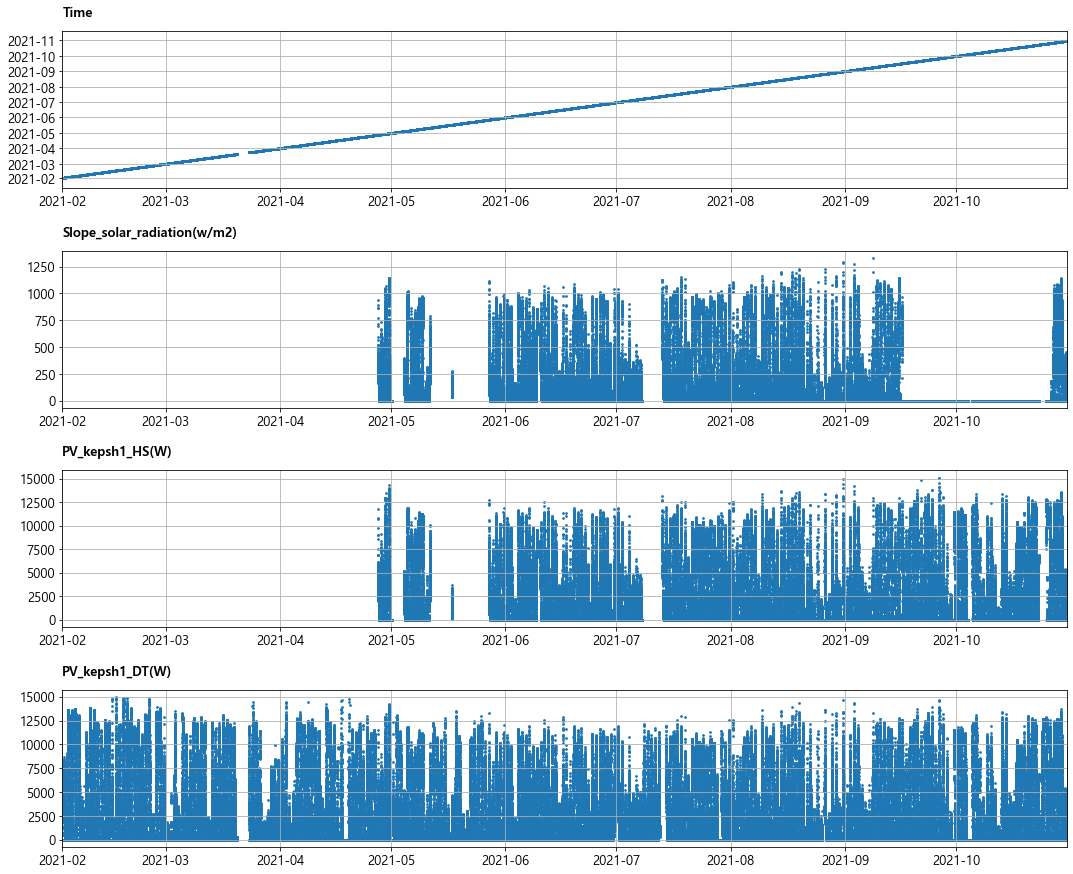

In [15]:
fig, ax = plt.subplots(figsize=(18,15))


for i in range(len(df_kepsh1_all.columns)):
    plt.subplot(len(df_kepsh1_all.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.xlim(pd.Timestamp('2021-02-01'), pd.Timestamp('2021-10-31'))
    name = df_kepsh1_all.columns[i]
    plt.scatter(x=df_kepsh1_all['Time'], y=df_kepsh1_all[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()